### Group
### Timo Reents
### Timo Marks
### Sercan Dede
### Jonathan Hungerland
### Chinmay Chandratre

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15

# Task A

In [2]:
def generative_model(N, mu, sigma, W):
    
    data = []
    z_values = []
    for _ in range(N):
        z = np.random.normal(size=1)
        z_values.append(z)
        mean = np.array(W) * z + np.array(mu)
        cov = np.identity(2) * sigma ** 2
        data.append(np.random.multivariate_normal(mean=mean, cov=cov, size=1))
    
    return np.vstack(np.array(data)), np.array(z_values).flatten()
    

In [3]:
mu = [50, 15]
sigma = 3
W = [10, 25]
N = 100

generated_data = generative_model(N, mu, sigma, W)

# Task B

([], [])

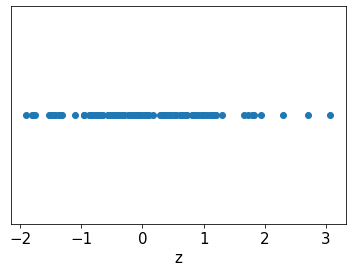

In [4]:
fig, ax = plt.subplots()

ax.scatter(generated_data[1], np.zeros(generated_data[1].shape))
ax.set_xlabel("z", fontsize=15)
plt.yticks([])

Text(0, 0.5, '$x_2$')

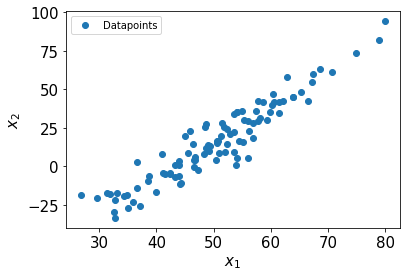

In [5]:
fig, ax = plt.subplots()

ax.scatter(generated_data[0][:, 0], generated_data[0][:, 1], label="Datapoints")

ax.legend()
ax.set_xlabel("$x_1$", fontsize=15)
ax.set_ylabel("$x_2$", fontsize=15)

# Task C

In [6]:
class DeterministicPCA:
    """
    Class that implements deterministic PCA.
    """
    
    def __init__(self, x):
        # data, shape: (number of data points, dimension)
        self.x = x
        # number of data points
        self.N = x.shape[0]
    
    def run(self):
        """
        Method to run the deterministic PCA process.
        """
        
        # Calculate mean     
        mu = self.x.mean(axis=0)
        x_ = self.x - mu
        
        # Calculate S
        S = 1 / self.N * (x_[:, :, None] * x_[:, None, :]).sum(axis=0)
        
        # Compute eigenvectors and eigenvalues
        eig_values, eig_vectors = np.linalg.eig(S)
        
        # Determine eigenvector that belongs to the eigenvalue with the largest absolute value
        idx_max_ev = np.argmax(np.abs(eig_values))
        
        return eig_vectors[:, idx_max_ev], mu
            

In [7]:
det_pca = DeterministicPCA(generated_data[0])

In [8]:
eig_vec, comp_mu = det_pca.run()

In [9]:
print(comp_mu)

[50.40632324 15.88282467]


Text(0, 0.5, '$x_2$')

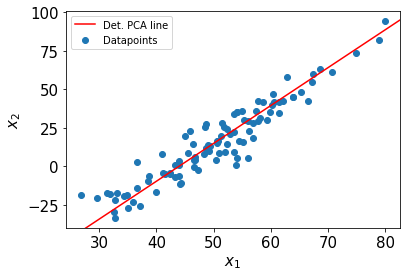

In [10]:
fig, ax = plt.subplots()

p1 = comp_mu
p2 = comp_mu + eig_vec

ax.scatter(generated_data[0][:, 0], generated_data[0][:, 1], label="Datapoints")
ax.axline(p1, p2, color="red", label="Det. PCA line")

ax.legend()
ax.set_xlabel("$x_1$", fontsize=15)
ax.set_ylabel("$x_2$", fontsize=15)

# Task D

In [11]:
class ProbabilisticPCA:
    
    def __init__(self, x, W, sigma, max_steps=100):
        
        self.x = x
        self.mu = self.x.mean(axis=0)
        self.W = W
        self.sigma = sigma
        self.N = self.x.shape[0] # number of data points
        self.D = self.x.shape[1] # Dimension of observation space
        self.max_steps = max_steps
           
    def _perform_e_step(self):
        
        
        self.M = self.W.transpose() @ self.W + self.sigma ** 2 * np.identity(self.W.shape[1])
        
        # Script equation 139
        self.mom1 = (np.linalg.inv(self.M) @ self.W.transpose()).dot((self.x - self.mu).transpose())
        # Script equation 140
        self.mom2 = self.sigma ** 2 * np.linalg.inv(self.M) + self.mom1.transpose()[:, :, None] * self.mom1.transpose()[:, None, :]
    
    def _perform_m_step(self):
        
        """
        Performs the m-step of the PCA EM algorithm.
        """
        
        # Script equation 142
        self.W = ((self.x - self.mu)[:, :, None] * self.mom1.transpose()[:, None, :]).sum(axis=0) @ np.linalg.inv(self.mom2.sum(axis=0))

        # Script equation 143
        sigma2 = (
            1 / (self.N * self.D) * (
                ((self.x - self.mu) * (self.x - self.mu)).sum(axis=1) + np.trace((self.W.transpose() @ self.W) @ self.mom2, axis1=1, axis2=2) 
                - 2 * (((self.x - self.mu) * (self.W @ self.mom1).transpose()).sum(axis=1))).sum()
        )
        self.sigma = np.sqrt(sigma2)        
        
    def _calculate_log_likelihood(self):

        """
        Calculate the log-likelihood. Script equation 172.
        """

        C = self.W @ self.W.transpose() + self.sigma ** 2 * np.identity(self.W.shape[0])
        S = 1 / self.N * ((self.x - self.mu)[:, :, None] * (self.x - self.mu)[:, None, :]).sum(axis=0)
        
        log_likelihood = (- self.N / 2 * (
            self.D * np.log(2 * np.pi) + np.log(np.linalg.det(C)) + np.trace(np.linalg.inv(C) @ S)
            )
        )
        
        return log_likelihood
    
    def run(self, print_=True, return_=True):

        """
        Run the EM algorithm.

        parameters:

        print_: Whether to print the log-likelihood in each step
        return_: Whether to return the list of log-likelihoods
        """
        
        converged = False
        step = 0
        log_likelihood = self._calculate_log_likelihood()
        log_likelihood_list = [log_likelihood]
        mu_parameters = [self.mu]
        sigma_parameters = [self.sigma]
        W_parameters = [self.W]
        if print_:
                print(f"step {step}: {log_likelihood}")
        
        # The actual algorithm
        while not converged and step < self.max_steps:
            
            self._perform_e_step()
            self._perform_m_step()
            
            log_likelihood = self._calculate_log_likelihood()

            # """ Save parameters in array or each iteration """
            log_likelihood_list.append(log_likelihood)
            mu_parameters.append(self.mu)
            sigma_parameters.append(self.sigma)
            W_parameters.append(self.W)
            step += 1
            
            if print_:
                print(f"step {step}: {log_likelihood}")
            
        if return_:
            return dict(mu= mu_parameters, sigma=sigma_parameters, W=W_parameters, log_likelihood=log_likelihood_list)
    
    def return_final_parameters(self):

        """
        Return the final parameters for the PCA model.
        """
        
        return {"mu": self.mu, "sigma": self.sigma, "W": self.W}
    
        

In [12]:
prob_pca = ProbabilisticPCA(generated_data[0], np.array([0.0, 10]).reshape(2, 1), 1, max_steps=50)

In [13]:
run_prob_pca = prob_pca.run(print_=False)

In [14]:
prob_pca_opt = prob_pca.return_final_parameters()
prob_pca_opt

{'mu': array([50.40632324, 15.88282467]),
 'sigma': 3.346054904037953,
 'W': array([[ 9.24571338],
        [22.75449392]])}

The parameters of the generative model are quite well approximated. Interesting to notice, the parameter W still changes significantly after 50 iterations (see date frame below). The 'convergence' of sigma is achieved after a few iterations (with respect to the first decimal digit).

Text(0.5, 1.0, 'The results of the deterministic and probabilistic PCA are nearly identical.')

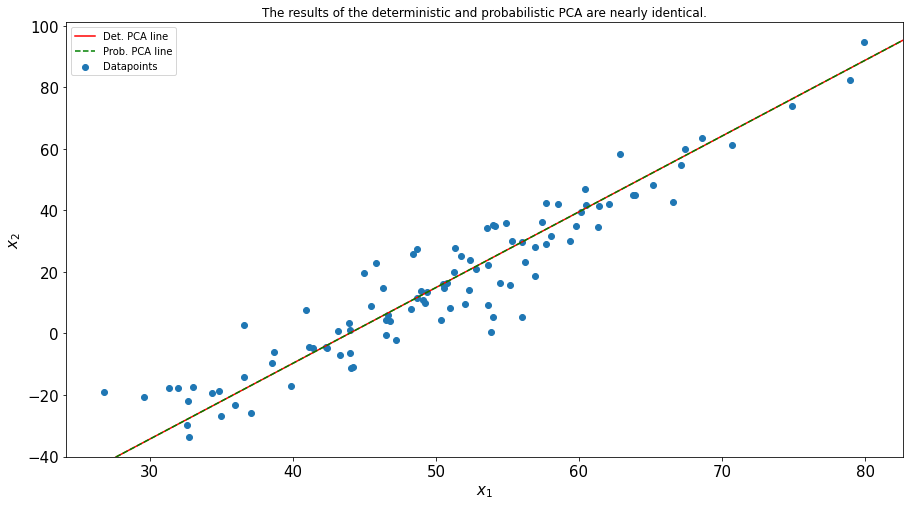

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))

p1_det = comp_mu
p2_det = comp_mu + eig_vec
p1_prob = prob_pca_opt.get("mu").flatten()
p2_prob = prob_pca_opt.get("mu").flatten() + prob_pca_opt.get("W").flatten()

ax.scatter(generated_data[0][:, 0], generated_data[0][:, 1], label="Datapoints")
ax.axline(p1_det, p2_det, color="red", label="Det. PCA line")
ax.axline(p1_prob, p2_prob, color="green", label="Prob. PCA line", linestyle="dashed")

ax.legend()
ax.set_xlabel("$x_1$", fontsize=15)
ax.set_ylabel("$x_2$", fontsize=15)
ax.set_title("The results of the deterministic and probabilistic PCA are nearly identical.")

Text(0, 0.5, 'Log-likelihood')

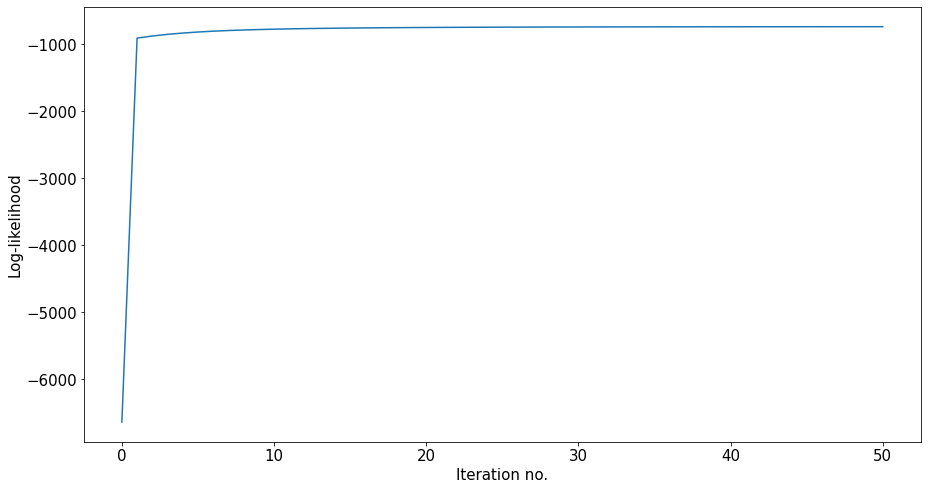

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))

log_likelihood = run_prob_pca.get("log_likelihood")

ax.plot(np.arange(len(log_likelihood)), log_likelihood)
ax.set_xlabel("Iteration no.", fontsize=15)
ax.set_ylabel("Log-likelihood", fontsize=15)

In [17]:
outputs = np.hstack((np.array(run_prob_pca.get("sigma")).reshape(-1, 1), np.hstack(run_prob_pca.get("W")).T))

In [18]:
pd.DataFrame(outputs, columns=["sigma", "W1", "W2"])

,sigma,W1,W2
0,1.000000,0.000000,10.000000
1,2.658207,4.028118,10.084516
2,3.047142,4.289890,10.560406
3,3.238328,4.538377,11.169377
4,3.334150,4.795309,11.801667
5,3.380021,5.045428,12.417230
6,3.399536,5.282345,13.000303
7,3.405518,5.504288,13.546524
8,3.404916,5.711525,14.056553
9,3.401404,5.905112,14.532988
